In [1]:
import warnings

import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as mno
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from causalgraphicalmodels import CausalGraphicalModel
from IPython.display import display
from patsy import dmatrix
from scipy import stats
from scipy.interpolate import griddata
from theano import shared

warnings.simplefilter(action="ignore", category=FutureWarning)

# az.style.use("arviz-darkgrid")
sns.set_theme()
az.rcParams["stats.hdi_prob"] = 0.95

In [2]:
def standardize(array, reference=None, use_std=True):
    if reference is None:
        reference = array
    return (array - reference.mean()) / (reference.std() if use_std else 1)

In [3]:
def unstandardize(array, reference, use_std=True):
    return array * (reference.std() if use_std else 1) + reference.mean()

# 5H1

In [4]:
d = pd.read_csv("data/foxes.csv", delimiter=";")
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [5]:
d.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


In [6]:
d.drop("group", axis=1).corr()

,avgfood,groupsize,area,weight
avgfood,1.000000,0.901483,0.883104,-0.025039
groupsize,0.901483,1.000000,0.827594,-0.160994
area,0.883104,0.827594,1.000000,0.019477
weight,-0.025039,-0.160994,0.019477,1.000000


In [7]:
az.summary(d.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_2.5%,hdi_97.5%
group,17.207,8.003,2.00,29.00
avgfood,0.752,0.198,0.42,1.21
groupsize,4.345,1.539,2.00,8.00
area,3.169,0.928,1.73,5.07
weight,4.530,1.184,2.35,6.86


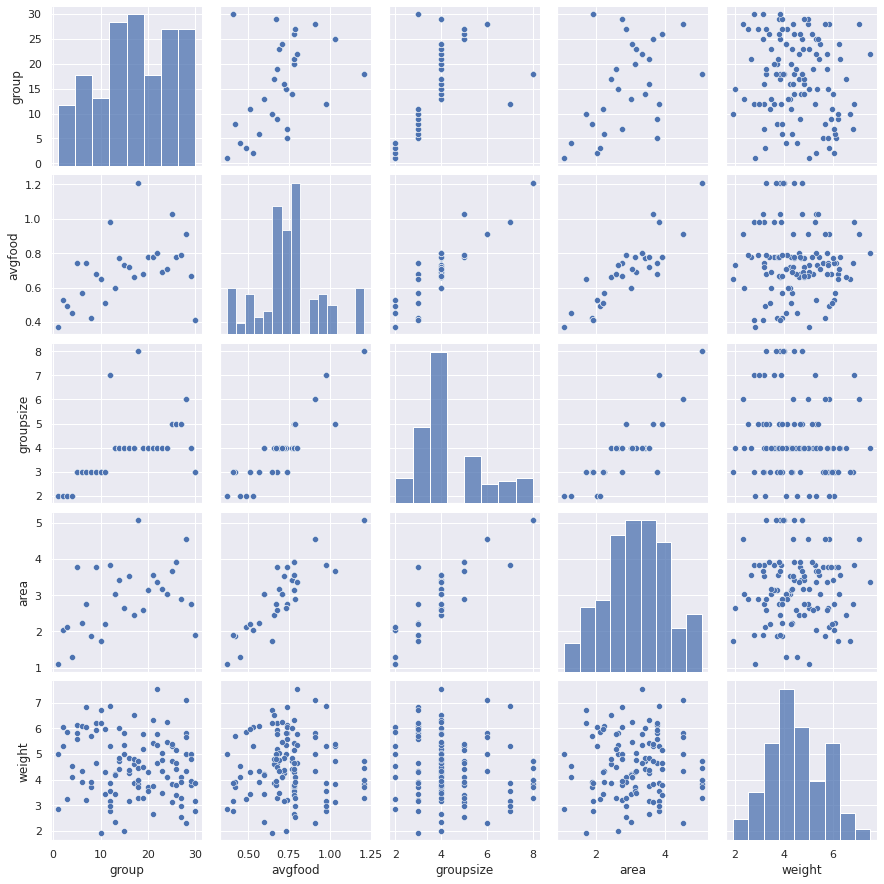

In [8]:
sns.pairplot(d)

In [9]:
for col in d.drop("group", axis=1).columns:
    d[f"{col}_s"] = standardize(d[col])

In [10]:
d.describe().T

,count,mean,std,min,25%,50%,75%,max
group,116.0,1.720690e+01,8.002736,1.000000,11.750000,18.000000,24.000000,30.000000
avgfood,116.0,7.517241e-01,0.198316,0.370000,0.660000,0.735000,0.800000,1.210000
groupsize,116.0,4.344828e+00,1.538511,2.000000,3.000000,4.000000,5.000000,8.000000
area,116.0,3.169138e+00,0.928354,1.090000,2.590000,3.130000,3.772500,5.070000
weight,116.0,4.529655e+00,1.184023,1.920000,3.720000,4.420000,5.375000,7.550000
avgfood_s,116.0,3.024401e-16,1.000000,-1.924829,-0.462515,-0.084331,0.243429,2.310838
groupsize_s,116.0,-1.741902e-16,1.000000,-1.524089,-0.874110,-0.224131,0.425848,2.375785
area_s,116.0,-6.393353e-16,1.000000,-2.239596,-0.623833,-0.042158,0.649927,2.047562
weight_s,116.0,4.230333e-16,1.000000,-2.204059,-0.683817,-0.092612,0.713960,2.550918


In [11]:
with pm.Model() as m5h1_area:
    a = pm.Normal("a", 0, 1)
    b_area = pm.Normal("b_area", 0, 1)
    mu = pm.Deterministic("mu", a + b_area * d.area_s)
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu=mu, sigma=sigma, observed=d.weight_s.values)
    m5h1_area_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_area, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


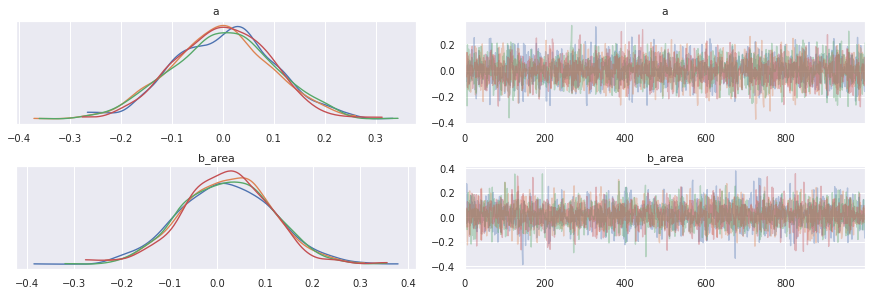

In [12]:
az.plot_trace(m5h1_area_trace, var_names=["a", "b_area"]);

[Text(0.5, 0, 'area'), Text(0, 0.5, 'weight')]

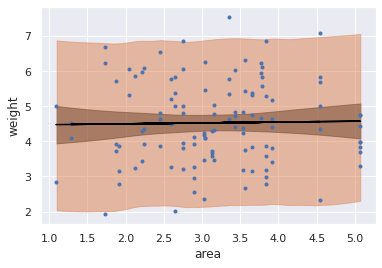

In [13]:
weight_pred = pm.fast_sample_posterior_predictive(m5h1_area_trace, model=m5h1_area)[
    "weight_s"
]
fig, ax = plt.subplots()
ax.plot(d.area, d.weight, ".")
ax.plot(d.area, unstandardize(m5h1_area_trace.mu.mean(axis=0), d.weight), color="black")
az.plot_hdi(d.area, unstandardize(m5h1_area_trace.mu, d.weight), ax=ax, color="black")
az.plot_hdi(d.area, unstandardize(weight_pred, d.weight), ax=ax)
ax.set(xlabel="area", ylabel="weight")

In [14]:
with pm.Model() as m5h1_groupsize:
    a = pm.Normal("a", 0, 1)
    b_groupsize = pm.Normal("b_groupsize", 0, 1)
    mu = pm.Deterministic("mu", a + b_groupsize * d.groupsize_s)
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu=mu, sigma=sigma, observed=d.weight_s.values)
    m5h1_groupsize_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_groupsize, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


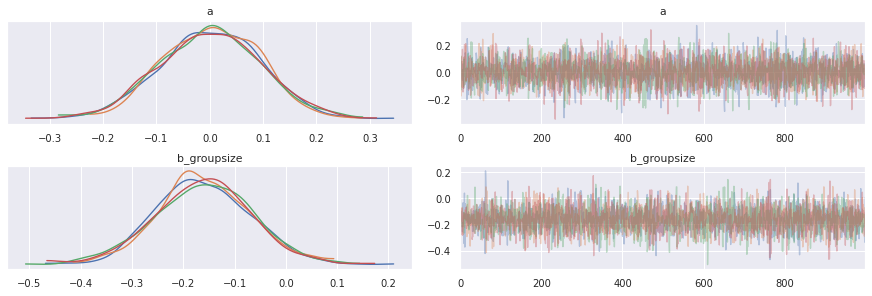

In [15]:
az.plot_trace(m5h1_groupsize_trace, var_names=["a", "b_groupsize"]);

[Text(0.5, 0, 'group size'), Text(0, 0.5, 'weight')]

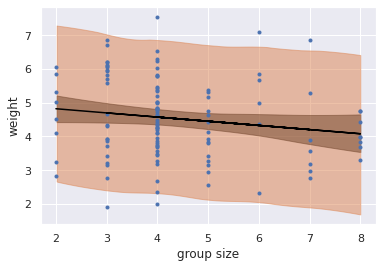

In [16]:
weight_pred = pm.fast_sample_posterior_predictive(
    m5h1_groupsize_trace, model=m5h1_groupsize
)["weight_s"]
fig, ax = plt.subplots()
ax.plot(d.groupsize, d.weight, ".")
ax.plot(
    d.groupsize,
    unstandardize(m5h1_groupsize_trace.mu.mean(axis=0), d.weight),
    color="black",
)
az.plot_hdi(
    d.groupsize, unstandardize(m5h1_groupsize_trace.mu, d.weight), ax=ax, color="black"
)
az.plot_hdi(d.groupsize, unstandardize(weight_pred, d.weight), ax=ax)
ax.set(xlabel="group size", ylabel="weight")

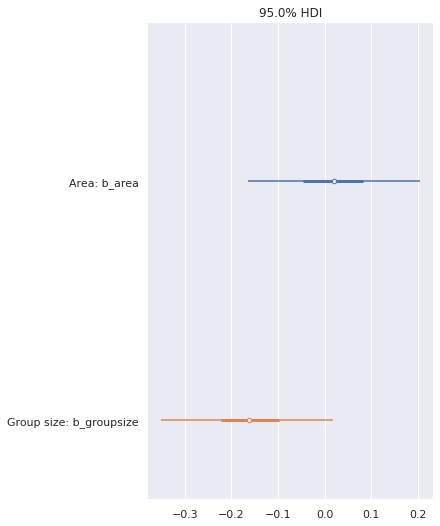

In [17]:
az.plot_forest(
    [m5h1_area_trace, m5h1_groupsize_trace],
    model_names=["Area", "Group size"],
    var_names=["b_area", "b_groupsize"],
    combined=True,
    hdi_prob=0.95,
);

# 5H2

In [18]:
with pm.Model() as m5h2:
    a = pm.Normal("a", 0, 1)
    area_s = pm.Data("area_s", d.area_s.values)
    groupsize_s = pm.Data("groupsize_s", d.groupsize_s.values)
    b_area = pm.Normal("b_area", 0, 1)
    b_groupsize = pm.Normal("b_groupsize", 0, 1)
    mu = pm.Deterministic("mu", a + b_area * area_s + b_groupsize * groupsize_s)
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu=mu, sigma=sigma, observed=d.weight_s.values)
    m5h2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_groupsize, b_area, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8796460984423136, but should be close to 0.8. Try to increase the number of tuning steps.


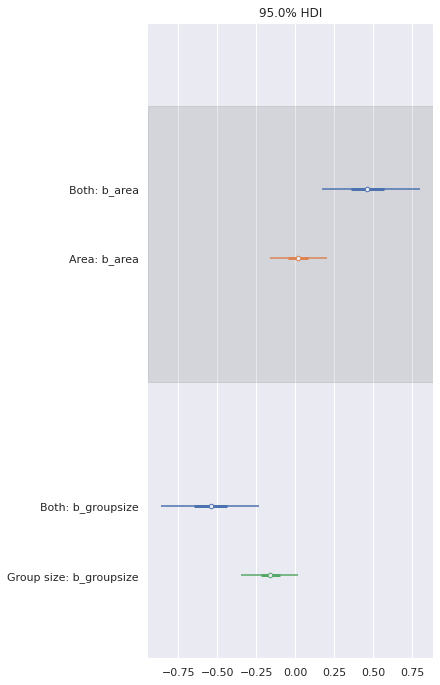

In [19]:
az.plot_forest(
    [m5h2_trace, m5h1_area_trace, m5h1_groupsize_trace],
    model_names=["Both", "Area", "Group size"],
    var_names=["b_area", "b_groupsize"],
    combined=True,
    hdi_prob=0.95,
);

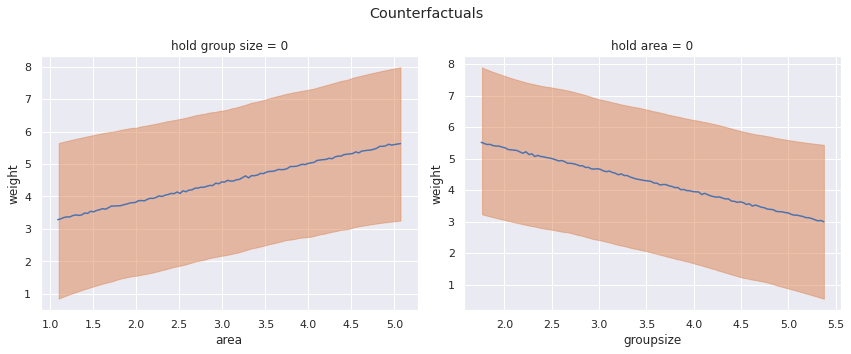

In [20]:
fig, (ax_area, ax_groupsize) = plt.subplots(ncols=2, figsize=(12, 5))
with m5h2:
    area_s_seq = np.linspace(d.area_s.min(), d.area_s.max(), num=len(d))
    area_seq = unstandardize(area_s_seq, d.area)

    groupsize_s_seq = np.linspace(d.groupsize_s.min(), d.groupsize_s.max(), num=len(d))
    groupsize_seq = unstandardize(groupsize_s_seq, d.area)

    pm.set_data({"area_s": area_s_seq})
    pm.set_data({"groupsize_s": np.zeros_like(d.groupsize_s)})
    weight_pred = pm.fast_sample_posterior_predictive(m5h2_trace)["weight_s"]

    ax_area.plot(area_seq, unstandardize(weight_pred, d.weight).mean(axis=0))
    az.plot_hdi(area_seq, unstandardize(weight_pred, d.weight), ax=ax_area)
    ax_area.set(xlabel="area", ylabel="weight", title="hold group size = 0")

    pm.set_data({"area_s": np.zeros_like(d.area_s)})
    pm.set_data({"groupsize_s": groupsize_s_seq})
    weight_pred = pm.fast_sample_posterior_predictive(m5h2_trace)["weight_s"]

    ax_groupsize.plot(groupsize_seq, unstandardize(weight_pred, d.weight).mean(axis=0))
    az.plot_hdi(groupsize_seq, unstandardize(weight_pred, d.weight), ax=ax_groupsize)
    ax_groupsize.set(xlabel="groupsize", ylabel="weight", title="hold area = 0")

    fig.suptitle("Counterfactuals")
    fig.tight_layout()

In [21]:
m5h2_trace.varnames

['a', 'b_area', 'b_groupsize', 'sigma_log__', 'mu', 'sigma']

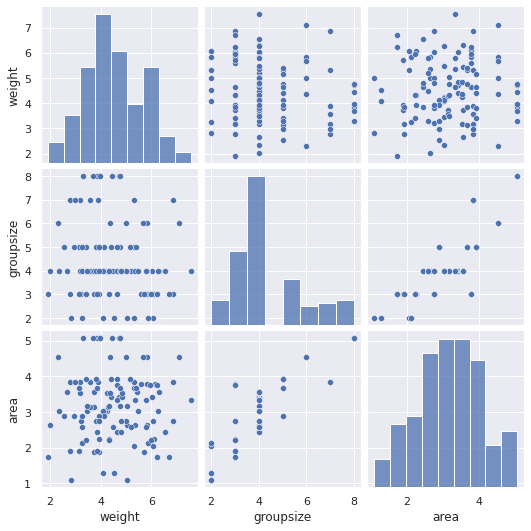

In [22]:
sns.pairplot(data=d[["weight", "groupsize", "area"]])

# 5H3

In [23]:
with pm.Model() as m5h3_food:
    a = pm.Normal("a", 0, 1)
    b_avgfood = pm.Normal("b_avgfood", 0, 1)
    mu = pm.Deterministic("mu", a + b_avgfood * d.avgfood_s)
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu=mu, sigma=sigma, observed=d.weight_s.values)
    m5h3_food_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_avgfood, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [24]:
with pm.Model() as m5h3_foodgroup:
    a = pm.Normal("a", 0, 1)
    b_groupsize = pm.Normal("b_groupsize", 0, 1)
    b_avgfood = pm.Normal("b_avgfood", 0, 1)
    mu = pm.Deterministic(
        "mu", a + b_groupsize * d.groupsize_s + b_avgfood * d.avgfood_s
    )
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu=mu, sigma=sigma, observed=d.weight_s.values)
    m5h3_foodgroup_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_avgfood, b_groupsize, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [25]:
with pm.Model() as m5h3_all:
    a = pm.Normal("a", 0, 1)
    b_area = pm.Normal("b_area", 0, 1)
    b_groupsize = pm.Normal("b_groupsize", 0, 1)
    b_avgfood = pm.Normal("b_avgfood", 0, 1)
    mu = pm.Deterministic(
        "mu",
        a + b_area * d.area_s + b_groupsize * d.groupsize_s + b_avgfood * d.avgfood_s,
    )
    sigma = pm.Exponential("sigma", 1)
    weight_s = pm.Normal("weight_s", mu=mu, sigma=sigma, observed=d.weight_s.values)
    m5h3_all_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_avgfood, b_groupsize, b_area, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.8812189213261928, but should be close to 0.8. Try to increase the number of tuning steps.


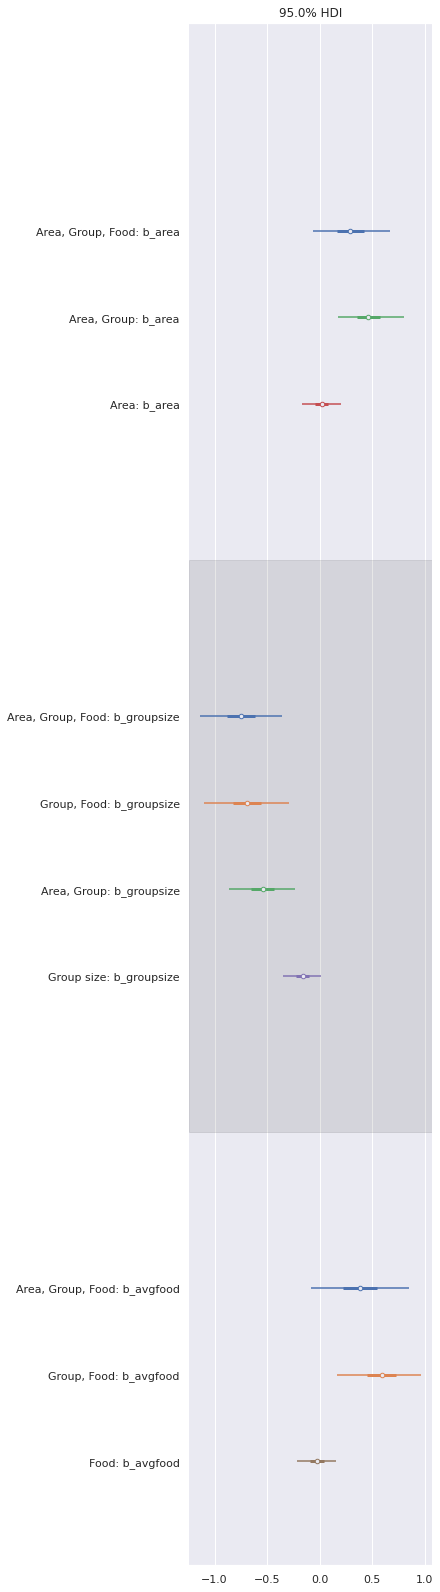

In [26]:
az.plot_forest(
    [
        m5h3_all_trace,
        m5h3_foodgroup_trace,
        m5h2_trace,
        m5h1_area_trace,
        m5h1_groupsize_trace,
        m5h3_food_trace,
    ],
    model_names=[
        "Area, Group, Food",
        "Group, Food",
        "Area, Group",
        "Area",
        "Group size",
        "Food",
    ],
    var_names=["b_area", "b_groupsize", "b_avgfood"],
    combined=True,
    hdi_prob=0.95,
);

In [27]:
az.summary(m5h3_all_trace)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.089,-0.168,0.178,0.001,0.002,3738.0,1691.0,3748.0,2863.0,1.0
b_area,0.294,0.190,-0.065,0.666,0.004,0.003,2703.0,2450.0,2688.0,2335.0,1.0
b_groupsize,-0.744,0.199,-1.135,-0.360,0.004,0.003,2604.0,2567.0,2602.0,2493.0,1.0
b_avgfood,0.384,0.237,-0.083,0.852,0.005,0.004,1987.0,1982.0,2003.0,2212.0,1.0
mu[0],-0.264,0.229,-0.712,0.192,0.004,0.003,3967.0,3656.0,3964.0,3485.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu[112],-0.125,0.104,-0.336,0.073,0.002,0.001,3735.0,3258.0,3735.0,3032.0,1.0
mu[113],-0.410,0.221,-0.855,0.019,0.004,0.003,2990.0,2990.0,2991.0,2897.0,1.0
mu[114],-0.410,0.221,-0.855,0.019,0.004,0.003,2990.0,2990.0,2991.0,2897.0,1.0
mu[115],-0.410,0.221,-0.855,0.019,0.004,0.003,2990.0,2990.0,2991.0,2897.0,1.0
